In [1]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import pymysql
from urllib.parse import urlparse
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import PassiveAggressiveClassifier

In [ ]:
df_train = pd.read_csv("data/train.csv") 

In [ ]:
X = df_train["text"]
y = df_train["label"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# Pre Process

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/axxe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df_train.isnull().sum()
df_train = df_train.fillna('')

In [ ]:
df_train['content'] = df_train['author']+' '+df_train['title']



In [ ]:
# Stemming is the process of reducing a word to Root word
ps= PorterStemmer()
def stemming(content):
    if not isinstance(content, str):
        content = str(content)
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content

In [ ]:
#df_train['content'] = df_train['content'].apply(stemming)

In [ ]:
#df_train['text_stem'] = df_train['text'].apply(stemming)

In [ ]:
#df_train.to_csv("data/stem_train.csv")
#df_train = pd.read_csv("data/stem_train.csv")
#df_train = df_train.fillna(' ')

In [ ]:
x = df_train['text'].values
y = df_train['label'].values

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x)

x = vectorizer.transform(x)

NameError: name 'x' is not defined

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.2, stratify=y, random_state=2)

In [ ]:
df_train["text"].shape

(20800,)

In [ ]:
df_train["content"].shape

(20800,)

# Baseline ( author + title )

## Log_Reg 

In [ ]:
models = LogisticRegression()
models.fit(x_train,y_train)

LogisticRegression()

In [ ]:
target_names = ['Real', 'Fake']

y_predict = models.predict(x_train)

training_data_acc = accuracy_score(y_predict,y_train)
print(f"Accuracy score: {training_data_acc}")

print(classification_report(y_train, y_predict, target_names=target_names))

Accuracy score: 0.9865985576923076
              precision    recall  f1-score   support

        Real       0.99      0.98      0.99      8310
        Fake       0.98      0.99      0.99      8330

    accuracy                           0.99     16640
   macro avg       0.99      0.99      0.99     16640
weighted avg       0.99      0.99      0.99     16640



# Baseline ( text )

In [ ]:
df_train = pd.read_csv("data/stem_train.csv")
#df_train = df_train.fillna(' ')
#df_train.to_csv("data/stem_train.csv")


In [ ]:
x1 = df_train['text'].values
y1 = df_train['label'].values

In [ ]:
vectorizer = TfidfVectorizer()
vec = vectorizer.fit(x1)

x1 = vec.transform(x1)

In [ ]:
x1[0]

<1x180445 sparse matrix of type '<class 'numpy.float64'>'
	with 357 stored elements in Compressed Sparse Row format>

In [ ]:
x1.shape

(20800, 180445)

In [ ]:
x1_train,x1_test,y1_train,y1_test = train_test_split(x1,y1,test_size = 0.2, stratify=y1, random_state=2)

## Log_Reg

In [ ]:

model = LogisticRegression()
model.fit(x1_train, y1_train)

# Prédire les étiquettes sur les données d'entraînement
y1_train_predict = model.predict(x1_test)

# Calculer l'exactitude sur les données d'entraînement
training_data_acc = accuracy_score(y1_test, y1_train_predict)
print(f"Accuracy score: {training_data_acc}")

# Afficher le rapport de classification
target_names = ['Real', 'Fake']
print(classification_report(y1_test, y1_train_predict, target_names=target_names))

# Calculer la courbe d'apprentissage
train_sizes, train_scores, val_scores = learning_curve(model, x1_train, y1_train, cv=5, scoring='accuracy')

# Calculer la moyenne et l'écart type des scores d'entraînement et de validation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure()
plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Score de validation")

plt.legend(loc="best")
plt.show()


## Passive Aggressive Classifier

In [ ]:
pac = PassiveAggressiveClassifier(C = 0.5, random_state = 5)
 
# Fitting model
pac.fit(x1_train, y1_train)
 
# Making prediction on test set
test_pred = pac.predict(x1_test)
 
# Model evaluation
print(f"Test Set Accuracy : {accuracy_score(y1_test, test_pred) * 100} %\n\n") 
 
target_names = ['Real', 'Fake']
print(classification_report(y1_test, test_pred, target_names=target_names))

Test Set Accuracy : 96.03365384615384 %


              precision    recall  f1-score   support

        Real       0.96      0.96      0.96      2077
        Fake       0.96      0.96      0.96      2083

    accuracy                           0.96      4160
   macro avg       0.96      0.96      0.96      4160
weighted avg       0.96      0.96      0.96      4160



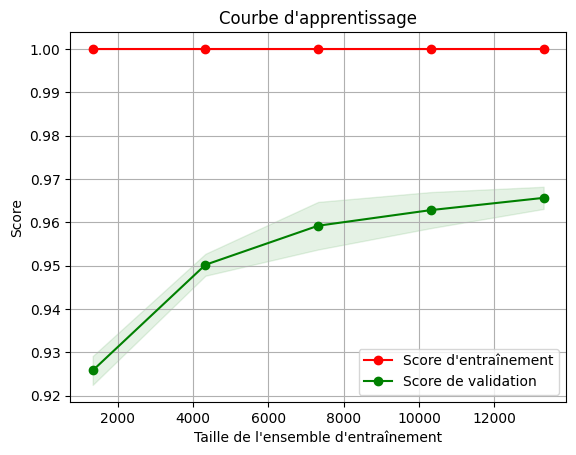

In [ ]:
# Calculer la courbe d'apprentissage
train_sizes, train_scores, val_scores = learning_curve(pac, x1_train, y1_train, cv=5, scoring='accuracy')

# Calculer la moyenne et l'écart type des scores d'entraînement et de validation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure()
plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Score de validation")

plt.legend(loc="best")
plt.show()

In [ ]:
# x1_train[0::]

## Pipeline v1

In [ ]:
pipeline = Pipeline([
    ('stemming', FunctionTransformer(func=stemming)),
    ('vectorizer', TfidfVectorizer()),
    ('model', LogisticRegression())
])

pipeline.fit(X_train, y_train)

y_test_predict = pipeline.predict(X_test)

test_data_acc = accuracy_score(y_test, y_test_predict)
print(f"Accuracy score: {test_data_acc}")

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

class MyTokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join(tokens) if isinstance(tokens, list) else tokens for tokens in X]


# Étape de tokenization
tokenizer = MyTokenizer()
x1_train_tokenized = tokenizer.transform(X_train)
x1_test_tokenized = tokenizer.transform(X_test)

print(x1_train_tokenized)
print(x1_test_tokenized)


# Vérification du vocabulaire
if not any(x1_train_tokenized):
    print("Le vocabulaire est vide. Vérifiez vos documents tokenisés.")
else:
    # Pipeline principal
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(stop_words='english')),
        ('model', LogisticRegression())
    ])

    pipeline.fit(x1_train_tokenized, y_train)

    y1_test_predict = pipeline.predict(x1_test_tokenized)

    test_data_acc = accuracy_score(y_test, y1_test_predict)
    print(f"Accuracy score: {test_data_acc}")





## XGBoost Classifier

In [ ]:
bst = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic')

In [ ]:
# fit model
bst.fit(x1_train, y1_train)
# make predictions
preds = bst.predict(x1_test)

training_data_acc = accuracy_score(y1_test, preds)
print(f"Accuracy score: {training_data_acc}")

target_names = ['Real', 'Fake']
print(classification_report(y1_test, preds, target_names=target_names))

Accuracy score: 0.9024038461538462
              precision    recall  f1-score   support

        Real       0.90      0.90      0.90      2077
        Fake       0.90      0.90      0.90      2083

    accuracy                           0.90      4160
   macro avg       0.90      0.90      0.90      4160
weighted avg       0.90      0.90      0.90      4160



In [ ]:
preds

array([1, 0, 1, ..., 1, 1, 0])

# Test

In [ ]:
df_test = pd.read_csv("data/stem_test.csv")

In [ ]:
df_test = df_test.fillna('')

In [ ]:
df_test

,Unnamed: 0,id,title,author,text,text_stem
0,0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",palo alto calif year scorn polit process silic...
1,1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...,russian warship readi strike terrorist near al...
2,2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,video nodapl nativ american leader vow stay wi...
3,3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",first succeed tri differ sport tim tebow heism...
4,4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,min ago view comment like first time histori f...
...,...,...,...,...,...,...
5195,5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...,dysfunct plagu world megac none may pernici ba...
5196,5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...,washington gov john kasich ohio tuesday sign l...
5197,5197,25997,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...,good morn want get california today email joan...
5198,5198,25998,300 US Marines To Be Deployed To Russian Borde...,,« Previous - Next » 300 US Marines To Be Deplo...,previou next us marin deploy russian border no...


In [ ]:
#df_test["text_stem"] = df_test['text'].apply(stemming)

In [ ]:
#df_test.to_csv("data/stem_test.csv")

In [ ]:
x2 = df_test["text_stem"].values
# x2[::]

In [ ]:
x2 = vectorizer.transform(x2)

In [ ]:
pac.predict(x2)

NameError: name 'pac' is not defined

# New Training

In [ ]:
new_df = pd.read_csv("data/WELFake_Dataset.csv")
new_df = new_df.drop("Unnamed: 0", axis=1)

In [ ]:
tot_df = pd.concat([df_train[["title", "text", "label"]],new_df], axis=0)
tot_df

,title,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...
72129,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0
72130,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1
72131,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0
72132,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0


In [ ]:
tot_df = tot_df.fillna(" ")

In [ ]:
tot_df['text_stem'] = tot_df['text'].apply(stemming)

In [ ]:
tot_df.to_csv("mega_train.csv")

NameError: name 'tot_df' is not defined

In [5]:
tot_df = pd.read_csv("data/mega_train.csv")
tot_df = tot_df.fillna(" ")

In [6]:
x5 = tot_df["text_stem"]
y5 = tot_df["label"]

In [7]:
vectorizer = TfidfVectorizer()
vectorizer.fit(x5)

x5 = vectorizer.transform(x5)

In [8]:
x5_train,x5_test,y5_train,y5_test = train_test_split(x5,y5,test_size = 0.2, stratify=y5, random_state=2)

## Log_reg Baseline

/home/axxe/.pyenv/versions/3.8.12/envs/nlp_fake_news/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy score: 0.9503954376714908
              precision    recall  f1-score   support

        Real       0.96      0.94      0.95      9083
        Fake       0.94      0.96      0.95      9504

    accuracy                           0.95     18587
   macro avg       0.95      0.95      0.95     18587
weighted avg       0.95      0.95      0.95     18587



/home/axxe/.pyenv/versions/3.8.12/envs/nlp_fake_news/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/axxe/.pyenv/versions/3.8.12/envs/nlp_fake_news/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

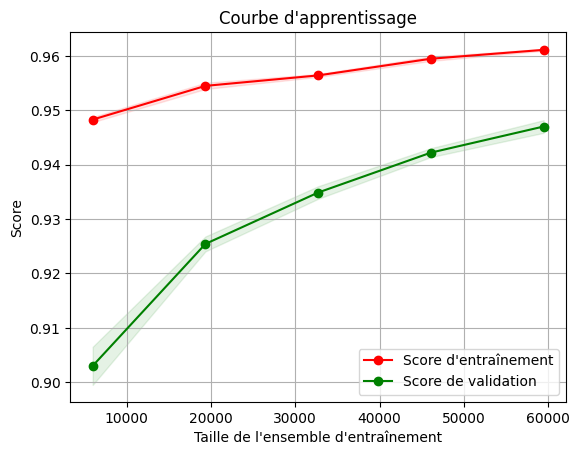

In [9]:
log_reg = LogisticRegression()
log_reg.fit(x5_train, y5_train)

# Prédire les étiquettes sur les données d'entraînement
y5_train_predict = log_reg.predict(x5_test)

# Calculer l'exactitude sur les données d'entraînement
training_data_acc = accuracy_score(y5_test, y5_train_predict)
print(f"Accuracy score: {training_data_acc}")

# Afficher le rapport de classification
target_names = ['Real', 'Fake']
print(classification_report(y5_test, y5_train_predict, target_names=target_names))

# Calculer la courbe d'apprentissage
train_sizes, train_scores, val_scores = learning_curve(log_reg, x5_train, y5_train, cv=5, scoring='accuracy')

# Calculer la moyenne et l'écart type des scores d'entraînement et de validation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure()
plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Score de validation")

plt.legend(loc="best")
plt.show()

## Log_reg ( CV )

/home/axxe/.pyenv/versions/3.8.12/envs/nlp_fake_news/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/axxe/.pyenv/versions/3.8.12/envs/nlp_fake_news/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

Cross-Validation Accuracy: 0.9470455734847845 +/- 0.0011363380853895533
              precision    recall  f1-score   support

        Real       0.96      0.94      0.95      9083
        Fake       0.94      0.96      0.95      9504

    accuracy                           0.95     18587
   macro avg       0.95      0.95      0.95     18587
weighted avg       0.95      0.95      0.95     18587



/home/axxe/.pyenv/versions/3.8.12/envs/nlp_fake_news/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/axxe/.pyenv/versions/3.8.12/envs/nlp_fake_news/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sci

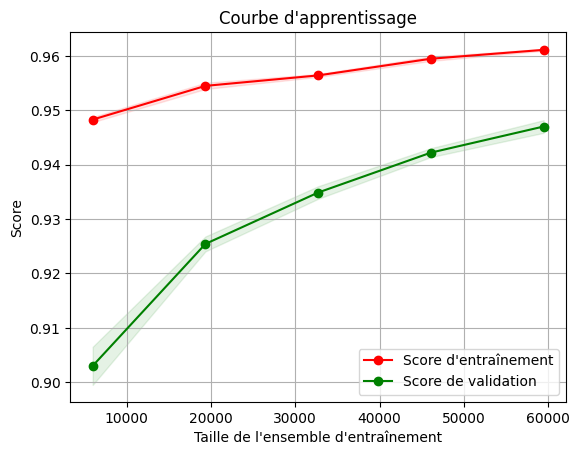

In [ ]:
log_reg = LogisticRegression()

# Effectuer la validation croisée
cv_scores = cross_val_score(log_reg, x5_train, y5_train, cv=5, scoring='accuracy')

# Calculer la moyenne et l'écart type des scores de validation croisée
cv_scores_mean = np.mean(cv_scores)
cv_scores_std = np.std(cv_scores)

print(f"Cross-Validation Accuracy: {cv_scores_mean} +/- {cv_scores_std}")

# Afficher le rapport de classification
target_names = ['Real', 'Fake']
print(classification_report(y5_test, y5_train_predict, target_names=target_names))

# Calculer la courbe d'apprentissage
train_sizes, train_scores, val_scores = learning_curve(log_reg, x5_train, y5_train, cv=5, scoring='accuracy')

# Calculer la moyenne et l'écart type des scores d'entraînement et de validation
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Tracer la courbe d'apprentissage
plt.figure()
plt.title("Courbe d'apprentissage")
plt.xlabel("Taille de l'ensemble d'entraînement")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Score de validation")

plt.legend(loc="best")
plt.show()


## XGBoost Classifier

In [ ]:
bst = XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic')

In [ ]:
# fit model
bst.fit(x5_train, y5_train)
# make predictions
preds = bst.predict(x5_test)

training_data_acc = accuracy_score(y5_test, preds)
print(f"Accuracy score: {training_data_acc}")

target_names = ['Real', 'Fake']
print(classification_report(y5_test, preds, target_names=target_names))

Accuracy score: 0.9083230214666165
              precision    recall  f1-score   support

        Real       0.92      0.89      0.90      9083
        Fake       0.90      0.93      0.91      9504

    accuracy                           0.91     18587
   macro avg       0.91      0.91      0.91     18587
weighted avg       0.91      0.91      0.91     18587



# Submission to Kaggle

In [ ]:
'''sub = bst.predict(x2)

submit = df_test
submission = pd.DataFrame({
    'id': df_test['id'],
    'label': sub
})
submission = submission.set_index("id")'''

In [ ]:
'''submission.to_csv("submits.csv")'''